In [1]:
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt

In [2]:
# Load the stock price data from a CSV file into a Pandas DataFrame
df = pd.read_csv("HINDALCO_1D.csv", parse_dates=['datetime'], index_col='datetime')

# Define the period length for the RSI indicator
period_length = 14

# Calculate the RSI indicator
df["rsi"] = ta.momentum.RSIIndicator(df["close"], window=period_length).rsi()


In [3]:

# Create a new DataFrame with a daily datetime index
date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq="D")
df_interp = pd.DataFrame(index=date_range)

# Merge the original DataFrame with the interpolated DataFrame
df_interp = pd.merge(df_interp, df, how="left", left_index=True, right_index=True)

# Interpolate the missing values
df_interp = df_interp.interpolate(method="linear")

# Reset the index
df_interp = df_interp.reset_index()

# Rename the index column
df_interp = df_interp.rename(columns={"index": "datetime"})

df_interp = df_interp.set_index("datetime")

# Print the interpolated DataFrame
print(df_interp)


                 close        high         low        open     volume   
datetime                                                                
2014-01-24  114.000000  115.350000  113.000000  113.150000  5737135.0  \
2014-01-25  113.033333  114.466667  111.766667  112.766667  6732949.0   
2014-01-26  112.066667  113.583333  110.533333  112.383333  7728763.0   
2014-01-27  111.100000  112.700000  109.300000  112.000000  8724577.0   
2014-01-28  113.800000  115.000000  109.750000  110.000000  4513345.0   
...                ...         ...         ...         ...        ...   
2018-12-24  217.850000  224.000000  216.950000  224.000000  4667022.0   
2018-12-25  218.225000  221.900000  214.925000  218.925000  5610943.5   
2018-12-26  218.600000  219.800000  212.900000  213.850000  6554865.0   
2018-12-27  220.600000  223.900000  219.600000  221.400000  7947144.0   
2018-12-28  223.500000  226.050000  221.000000  221.000000  5074920.0   

           instrument        rsi  
datetime       

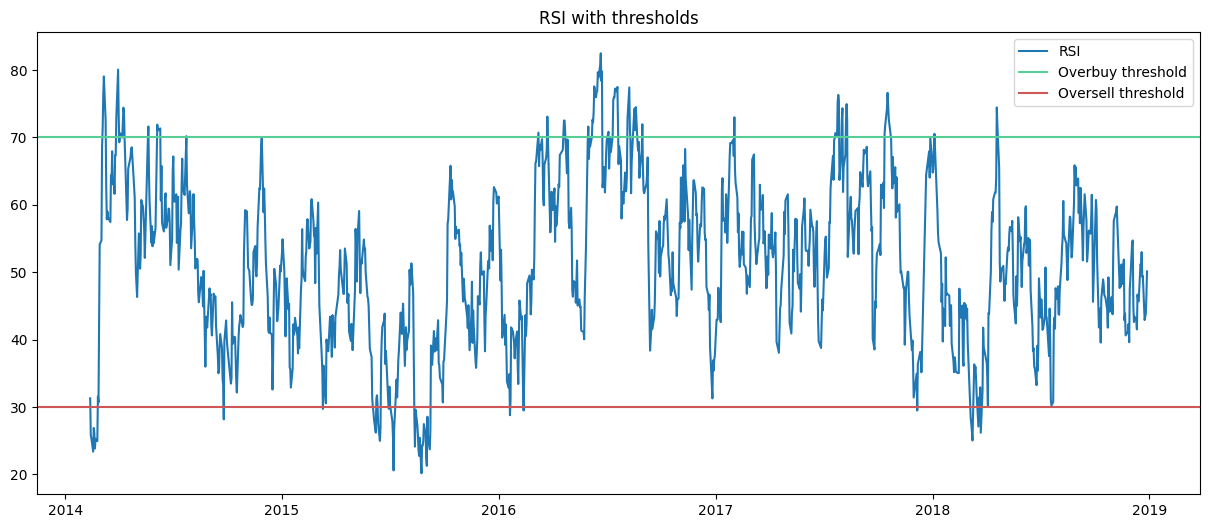

In [4]:

plt.figure(figsize=(15, 6))

# View the RSI
plt.plot(df_interp["rsi"])

# View horizontal line for the Overbuy threshold (RSI=70)
plt.axhline(70, color="#57CE95")

# View horizontal line for the Oversell threshold (RSI=30)
plt.axhline(30, color="#CE5757")

# Put a title
plt.title("RSI with thresholds")

# Put a legend
plt.legend(["RSI", "Overbuy threshold", "Oversell threshold"])

# Show the graph
plt.show()


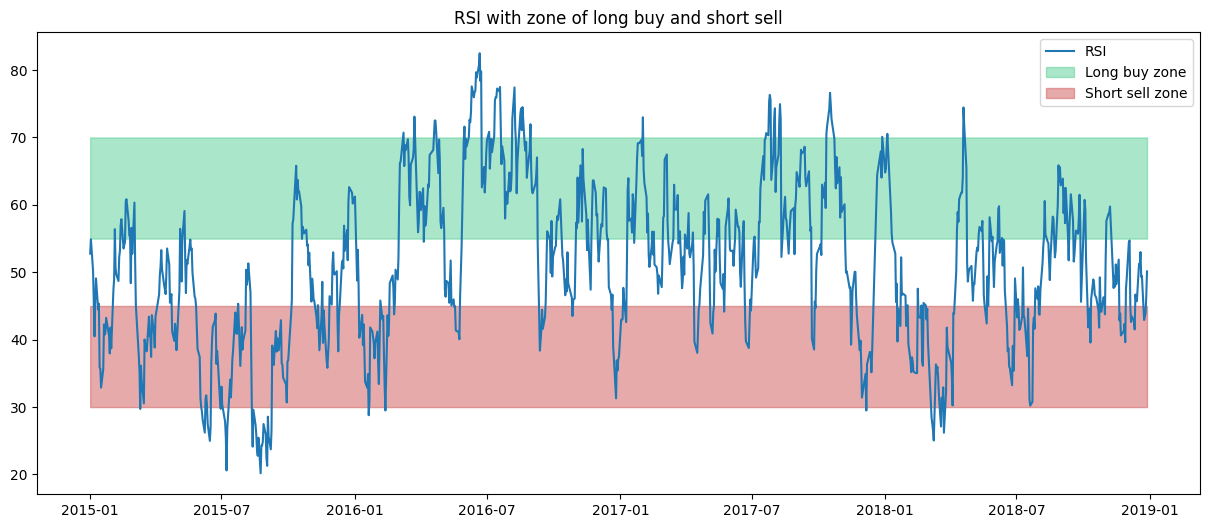

In [5]:

df = df_interp.loc["2015":]

plt.figure(figsize=(15,6))

# View the RSI
plt.plot(df["rsi"])

# View horizontal line for the Overbuy threshold (RSI=70)
plt.fill_between(df["rsi"].index,55,
                 70, color="#57CE95",
                  alpha=0.5)

# View horizontal line for the Oversell threshold (RSI=30)
plt.fill_between(df["rsi"].index,45,
                 30, color="#CE5757",
                  alpha=0.5)
# Put a title
plt.title("RSI with zone of long buy and short sell")

# Put a legend
plt.legend(["RSI", "Long buy zone", "Short sell zone"])

# Show the graph
plt.show()

In [6]:
overbuy = 70
neutral_buy = 55

# Put nan values for the signal long columns
df["signal_long"] = np.nan
df["yersteday_rsi"] = df["rsi"].shift(1)

# We need define the Open Long signal (RSI yersteday<55 and RSI today>55)
df.loc[(df["rsi"]>neutral_buy) & (df["yersteday_rsi"] < neutral_buy), "signal_long" ] = 1

df.loc[(df["rsi"]<neutral_buy) & (df["yersteday_rsi"] > neutral_buy), "signal_long" ] = 0

# We need define the Close Long signal (RSI yersteday>70 and RSI today<70) Over buy signal
df.loc[(df["rsi"] < overbuy) & (df['yersteday_rsi'] > overbuy), "signal_long"] = 0

/tmp/ipykernel_838004/3338156840.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["signal_long"] = np.nan
/tmp/ipykernel_838004/3338156840.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["yersteday_rsi"] = df["rsi"].shift(1)


In [7]:
idx_open = df.loc[df['signal_long'] == 1].index
idx_close = df.loc[df['signal_long'] == 0].index

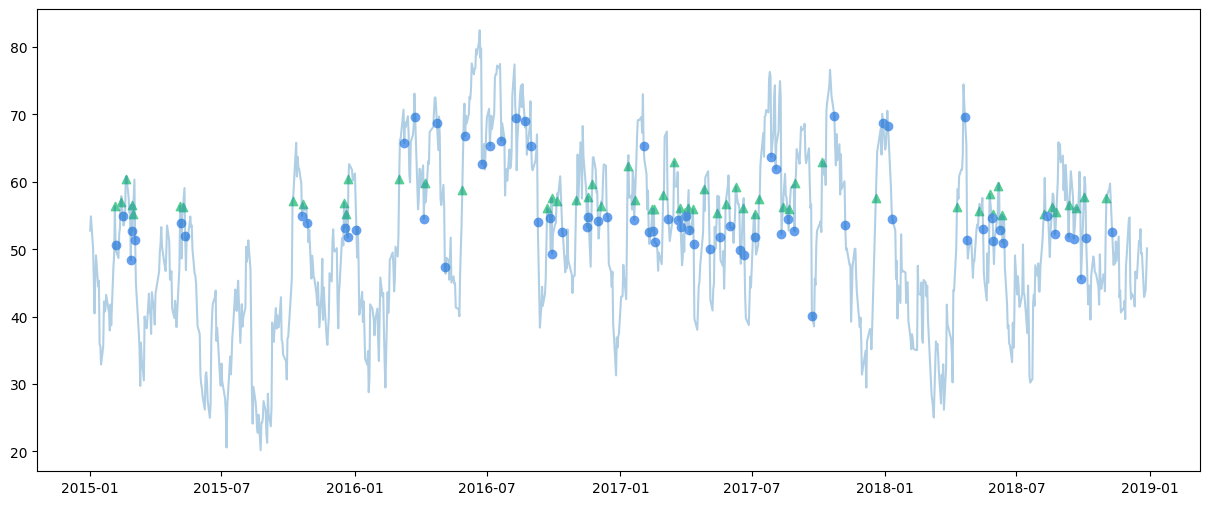

In [8]:
plt.figure(figsize=(15,6))

# Plot the points of the open long signal in green
plt.scatter(df.loc[idx_open]["rsi"].index, df.loc[idx_open]["rsi"], color= "#57CE95", marker="^")

# Plot the points of the close long signal in blue
plt.scatter(df.loc[idx_close]["rsi"].index, df.loc[idx_close]["rsi"], color= "#669FEE", marker="o")

# Plot the rsi to be sure that the conditions are completed
plt.plot(df["rsi"].index, df["rsi"], alpha=0.35)

# Show the graph
plt.show() 

In [9]:
oversell = 30
neutral_buy = 45

# Put nan values for the signal short columns
df["signal_short"] = np.nan
df["yersteday_rsi"] = df["rsi"].shift(1)
# We need define the Open short signal (RSI yersteday>45 and RSI today<45)
df.loc[(df["rsi"]<neutral_buy) & (df["yersteday_rsi"]>neutral_buy), "signal_short"] = -1

# We need define the Close short signal (RSI yersteday<45 and RSI today>45) False signal
df.loc[(df["rsi"]>neutral_buy)&(df["yersteday_rsi"]<neutral_buy), "signal_short"] = 0

# We need define the Close short signal (RSI yersteday<30 and RSI today>30) Over sell signal
df.loc[(df["rsi"]>oversell)&(df["yersteday_rsi"]<oversell), "signal_short"] = 0

/tmp/ipykernel_838004/518697511.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["signal_short"] = np.nan
/tmp/ipykernel_838004/518697511.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["yersteday_rsi"] = df["rsi"].shift(1)


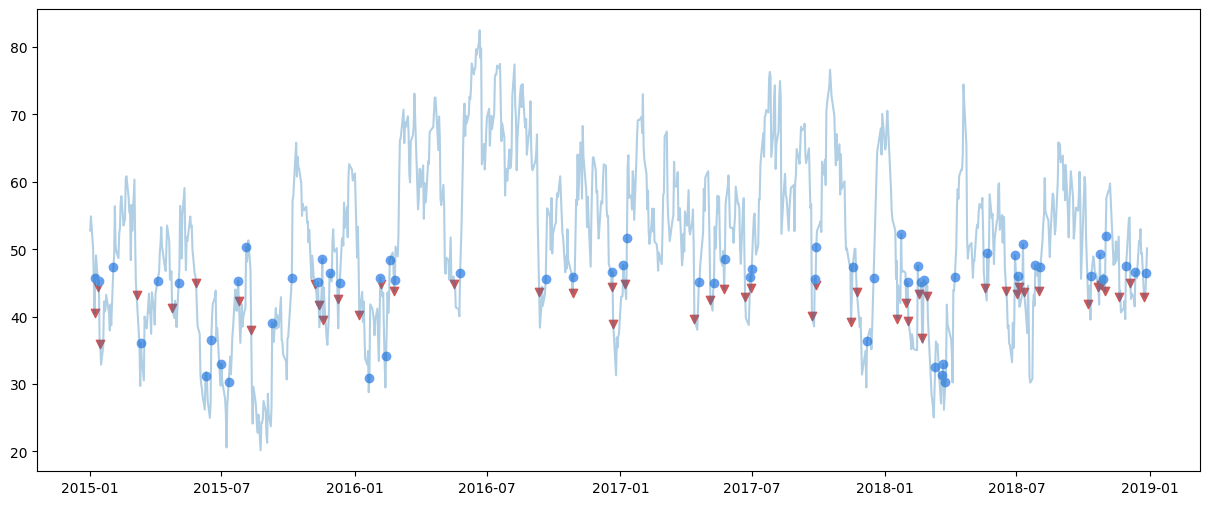

In [10]:
# We plot all the signal to be sure that they be correct

idx_open = df.loc[df["signal_short"]==-1].index
idx_close = df.loc[df["signal_short"]==0].index

# Adapt the size of the graph
plt.figure(figsize=(15,6))

# Plot the points of the open short signal in red
plt.scatter(df.loc[idx_open]["rsi"].index, df.loc[idx_open]["rsi"], color= "#CE5757", marker="v")

# Plot the points of the close short signal in blue
plt.scatter(df.loc[idx_close]["rsi"].index, df.loc[idx_close]["rsi"], color= "#669FEE", marker="o")

# Plot the rsi to be sure that the conditions are completed
plt.plot(df["rsi"].index, df["rsi"], alpha=0.35)

# Show the graph
plt.show()

In [11]:
df["Position"] = (df["signal_short"].fillna(method="ffill")+ df["signal_long"].fillna(method="ffill"))

/tmp/ipykernel_838004/1037580029.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Position"] = (df["signal_short"].fillna(method="ffill")+ df["signal_long"].fillna(method="ffill"))


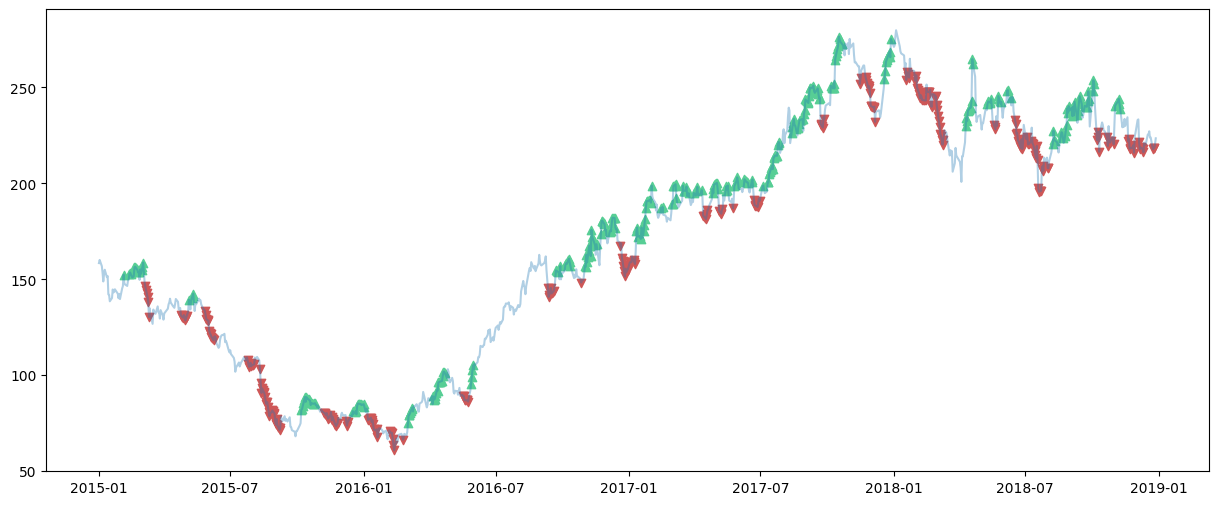

In [12]:
idx_long = df.loc[df["Position"]==1].index
idx_short = df.loc[df["Position"]==-1].index

# Adapt the size of the graph
plt.figure(figsize=(15,6))

# Plot the points of the short signal in red
plt.scatter(df.loc[idx_short]["close"].index, df.loc[idx_short]["close"], color= "#CE5757", marker="v")

# Plot the points of the long signal in green
plt.scatter(df.loc[idx_long]["close"].index, df.loc[idx_long]["close"], color= "#57CE95", marker="^")

# Plot the rsi to be sure that the conditions are completed
plt.plot(df["close"].index, df["close"], alpha=0.35)

# Show the graph
plt.show()

/tmp/ipykernel_838004/3434041105.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pct"] = df["close"].pct_change(1)
/tmp/ipykernel_838004/3434041105.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["return"] = df["pct"]*(df["Position"].shift(1))


<Axes: xlabel='datetime'>

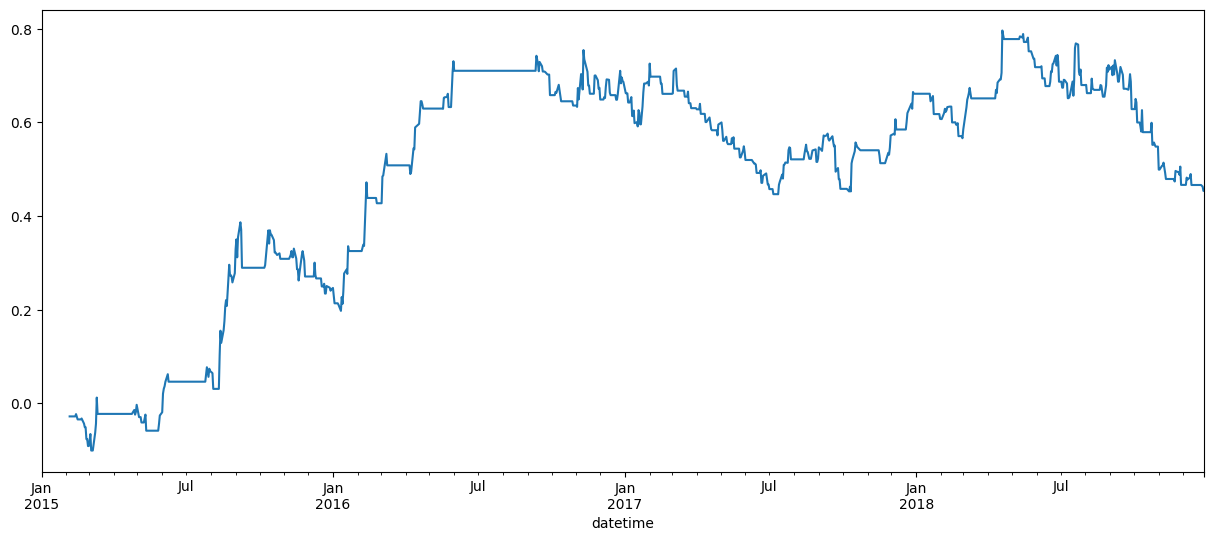

In [13]:
# Compute the percentage of variation of the asset
df["pct"] = df["close"].pct_change(1)

# Compute the return of the strategy
df["return"] = df["pct"]*(df["Position"].shift(1))

df["return"].cumsum().plot(figsize=(15,6))